### Problem description

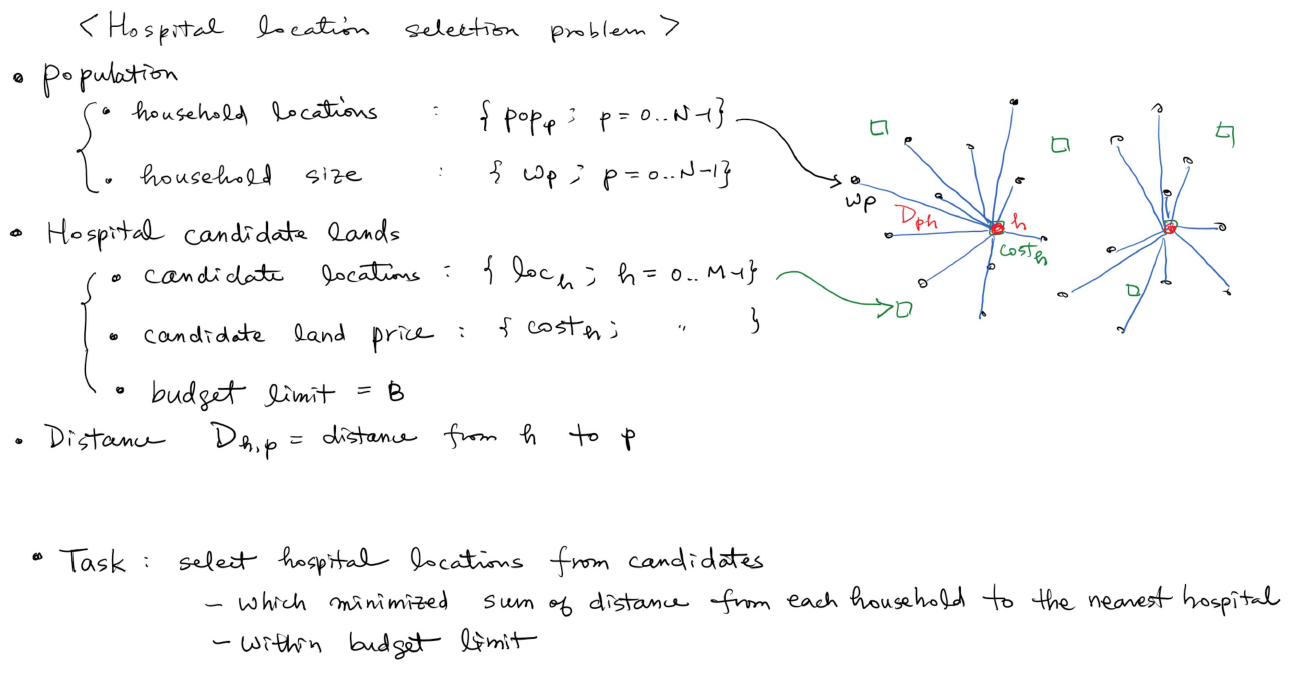

### Formulation as an Integer Programming (IP)

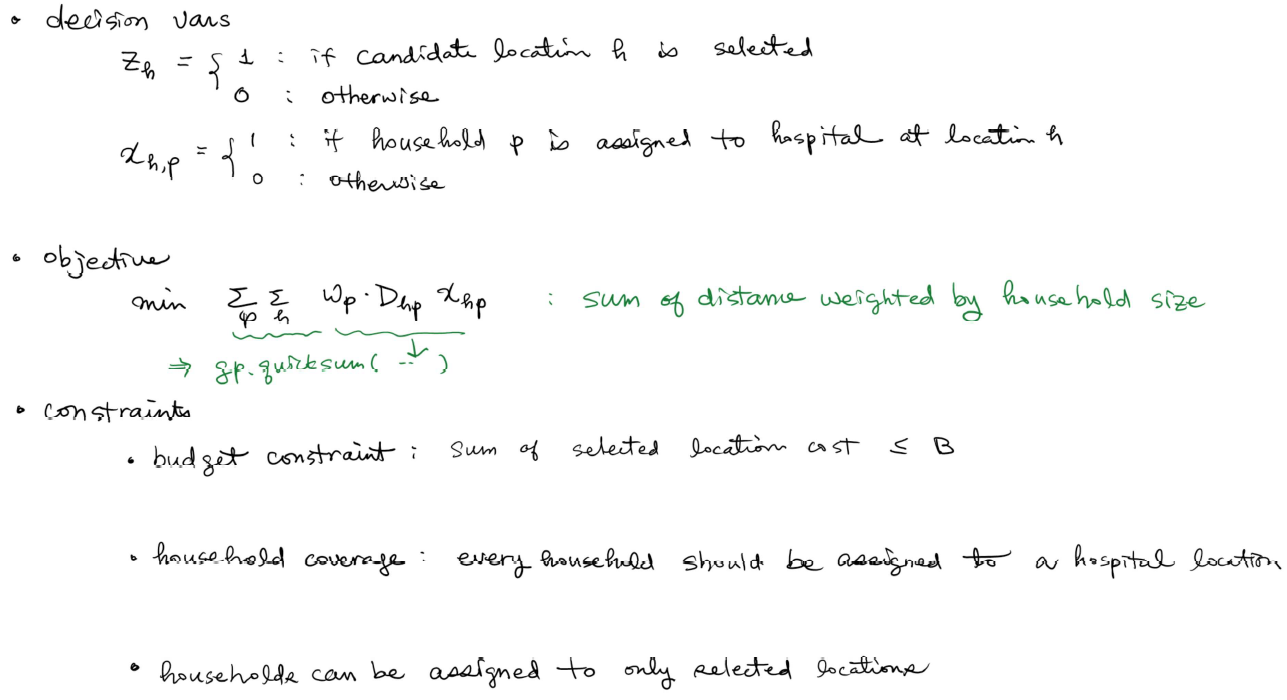

### 1. Importing packages

In [1]:
!pip install gurobipy

     |████████████████████████████████| 11.5 MB 3.8 MB/s 


In [2]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import pdist, squareform
import numpy as np

### 2. Generating population and locations

Initially, 1000 households and 100 locations are generated

In [3]:
def generate_population(N_pop, N_cen=5):
    n = N_pop // N_cen
    cen = np.random.random((N_cen, 2))
    sigma = 0.1
    for i in range(N_cen):
        if i == N_cen-1:
            n = N_pop - (n-1)*N_cen
        pop_i = cen[i,:] + sigma*np.random.randn(n,2)
        if i == 0: 
            pop = pop_i
        else:
            pop = np.append(pop, pop_i, axis=0)
    return pop

def generate_locations(N_loc, pop):
    min = pop.min(axis=0)
    max = pop.max(axis=0)
    d = max - min
    loc = np.random.random((N_loc, 2))
    loc = min + d * loc
    cost = 100 + np.random.random(N_loc) * 100
    return loc, cost

In [4]:
def plot_result(popi=None, popg=None, loc=None, x=None):
    plt.figure(figsize=(10,10), dpi=80)
    if popi is not None:
        plt.scatter(*zip(*popi), c='Pink', s=0.5)
    if popg is not None:
        plt.scatter(*zip(*popg), c='Red', s=10)
    if loc is not None:
        plt.scatter(*zip(*loc), c='Green', s=10)
    if x is not None:
        for p in range(popg.shape[0]):
            for h in range(loc.shape[0]):
                if x[h,p].x > 0.5:
                    pts = [loc[h], popg[p]]
                    plt.plot(*zip(*pts), c='Black', linewidth=0.1)

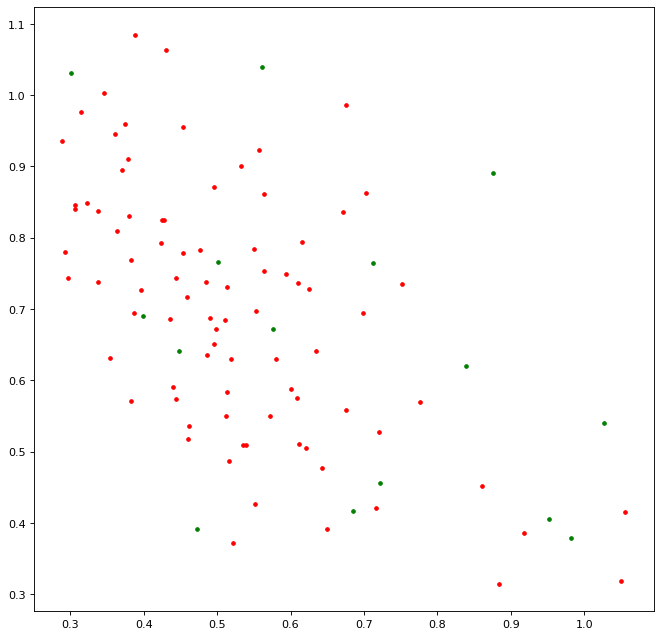

In [5]:
np.random.seed(0)
pop = generate_population(100)
loc, cost = generate_locations(15, pop)
budget = 500
plot_result(popg=pop, loc=loc)

### 3. Implementing hospital selection with Gurobi

In [6]:
def dist(loc1, loc2):
    return np.linalg.norm(loc1-loc2, ord=2) # Euclidean distance

def compute_distance(pop, loc):
    N_pop = pop.shape[0]
    N_loc = loc.shape[0]
    D = np.zeros((N_loc,N_pop))
    for p in range(N_pop):
        for h in range(N_loc):
            D[h,p] = dist(loc[h], pop[p])
    return D

In [7]:
D = compute_distance(pop, loc)

In [8]:
def solve_select_assign(pop, loc, budget, w=None, cost=None):
    # model
    hos_loc_model = gp.Model('hos loc')

    pop_size = pop.shape[0]
    loc_size = loc.shape[0]

    if w is None:
        w = [1 for i in range(pop_size)]

    if cost is None:
        cost = [1 for i in range(loc_size)]
    
    # variables
    x, z = {}, {}
    for h in range(loc_size):
        z[h] = hos_loc_model.addVar(vtype=GRB.BINARY, name=f'z{h}')
        for p in range(pop_size):
            x[h,p] = hos_loc_model.addVar(vtype=GRB.BINARY, name=f'x{h,p}')
    
    # objective
    hos_loc_model.setObjective(
        gp.quicksum(w[p]*D[h,p]*x[h,p] for h in range(loc_size) for p in range(pop_size)), 
        GRB.MINIMIZE)
    
    # constraints
    # budget constraint
    hos_loc_model.addConstr(gp.quicksum(z[h]*cost[h] for h in range(loc_size)) <= budget)

    # each house connected to only one hos
    for p in range(pop_size):
        hos_loc_model.addConstr(gp.quicksum(x[h,p] for h in range(loc_size)) == 1)
    
    # each house connected to only selected hos
    for h in range(loc_size):
        for p in range(pop_size):
            hos_loc_model.addConstr(x[h,p] <= z[h])

    # optimize model
    hos_loc_model.optimize()

    return hos_loc_model, x

Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 1361 rows, 1290 columns and 3840 nonzeros
Model fingerprint: 0xf49f1aa7
Variable types: 0 continuous, 1290 integer (1290 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Found heuristic solution: objective 18.8196987
Presolve time: 0.02s
Presolved: 1361 rows, 1290 columns, 3840 nonzeros
Variable types: 0 continuous, 1290 integer (1290 binary)

Root relaxation: objective 1.135408e+01, 368 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.35408    0   27   18.81970   11.35408  39.7%     -  

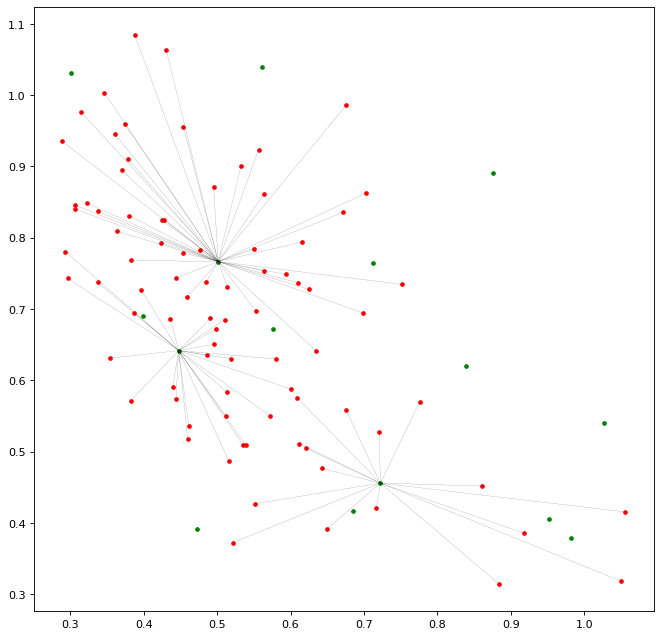

In [9]:
m, x = solve_select_assign(pop, loc, budget, cost=cost)
plot_result(popg=pop, loc=loc, x=x)